# import library

In [1]:
import os
import gc
import sys
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from collections import defaultdict
from multiprocessing import cpu_count, Pool

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

import warnings
warnings.simplefilter('ignore')

/anaconda/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [391]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 300

In [3]:
PATH = os.path.join('..', 'remove_outlier_data')
KEY = 'card_id'
SEED = 6
NTHREAD = cpu_count()
NFOLD = 5

# features

In [4]:
features = []

features += [f'f10{i}.pkl' for i in (2, 4, 6, 7)]
# features += [f'f11{i}_{j}.pkl' for i in (1,) 
#                                for j in ('Y', 'N')]
# features += [f'f12{i}.pkl' for i in (1,)]
# features += [f'f13{i}.pkl' for i in (1,)]
# features += [f'f14{i}.pkl' for i in (1,)]

features += [f'f20{i}.pkl' for i in (2, 4, 6, 7)]
# features += [f'f23{i}.pkl' for i in (1, 2)]

features += [f'f30{i}.pkl' for i in (2,)]

# read data and features

In [5]:
train = pd.read_csv(os.path.join(PATH, 'train.csv'))
test = pd.read_csv(os.path.join(PATH, 'test.csv'))

for f in tqdm(features):
    t = pd.read_pickle(os.path.join('..', 'remove_outlier_feature', f))
    train = pd.merge(train, t, on=KEY, how='left')
    test = pd.merge(test, t, on=KEY, how='left')

100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


#  add handcrafted features

In [6]:
df = pd.concat([train, test], axis=0)
df['first_active_month'] = pd.to_datetime(df['first_active_month'])

df['hist_first_buy'] = (df['hist_purchase_date_min'].dt.date - df['first_active_month'].dt.date).dt.days
df['hist_last_buy'] = (df['hist_purchase_date_max'].dt.date - df['first_active_month'].dt.date).dt.days
df['new_first_buy'] = (df['new_purchase_date_min'].dt.date - df['first_active_month'].dt.date).dt.days
df['new_last_buy'] = (df['new_purchase_date_max'].dt.date - df['first_active_month'].dt.date).dt.days

date_features = [
    'hist_purchase_date_max','hist_purchase_date_min',
    'new_purchase_date_max', 'new_purchase_date_min',
]

for f in date_features:
    df[f] = df[f].astype(np.int64) * 1e-9

df['card_id_total'] = df['new_card_id_size'] + df['hist_card_id_size']
df['card_id_cnt_total'] = df['new_card_id_count'] + df['hist_card_id_count']
df['card_id_cnt_ratio'] = df['new_card_id_count'] / df['hist_card_id_count']
df['purchase_amount_total'] = df['new_purchase_amount_sum'] + df['hist_purchase_amount_sum']
df['purchase_amount_mean'] = df['new_purchase_amount_mean'] + df['hist_purchase_amount_mean']
df['purchase_amount_max'] = df['new_purchase_amount_max'] + df['hist_purchase_amount_max']
df['purchase_amount_min'] = df['new_purchase_amount_min'] + df['hist_purchase_amount_min']
df['purchase_amount_ratio'] = df['new_purchase_amount_sum'] / df['hist_purchase_amount_sum']
df['month_diff_mean'] = df['new_month_diff_mean'] + df['hist_month_diff_mean']
df['month_diff_ratio'] = df['new_month_diff_mean'] / df['hist_month_diff_mean']
df['month_lag_mean'] = df['new_month_lag_mean'] + df['hist_month_lag_mean']
df['category_1_mean'] = df['new_category_1_mean'] + df['hist_category_1_mean']
df['installments_mean'] = df['new_installments_mean'] + df['hist_installments_mean']
df['installments_max'] = df['new_installments_max'] + df['hist_installments_max']
df['price_mean'] = df['purchase_amount_mean'] / df['installments_mean']
df['price_max'] = df['purchase_amount_max'] / df['installments_max']
df['duration_mean'] = df['new_duration_mean'] + df['hist_duration_mean']
df['duration_min'] = df['new_duration_min'] + df['hist_duration_min']
df['duration_max'] = df['new_duration_max'] + df['hist_duration_max']
df['amount_month_ratio_mean'] = df['new_amount_month_ratio_mean'] + df['hist_amount_month_ratio_mean']
df['amount_month_ratio_min'] = df['new_amount_month_ratio_min'] + df['hist_amount_month_ratio_min']
df['amount_month_ratio_max'] = df['new_amount_month_ratio_max'] + df['hist_amount_month_ratio_max']
df['new_CLV'] = df['new_card_id_count'] * df['new_purchase_amount_sum'] / df['new_month_diff_mean']
df['hist_CLV'] = df['hist_card_id_count'] * df['hist_purchase_amount_sum'] / df['hist_month_diff_mean']
df['CLV_ratio'] = df['new_CLV'] / df['hist_CLV']

In [7]:
train = df[df['target'].notnull()]
test = df[df['target'].isnull()]

del df
gc.collect()

404

# preprocess

In [118]:
train['nan_count'] = train.isnull().sum(axis=1)
test['nan_count'] = test.isnull().sum(axis=1)

y = train['target']

col_not_to_use = [
    'first_active_month', 'card_id', 'target', 'outliers', 'hist_card_id_size', 'new_card_id_size'
]

# feature selection

In [61]:
for c in train.columns:
    print(c, train[c].dtypes, train[c].max(), test[c].max())

card_id object C_ID_fffffd5772 C_ID_ffff756266
feature_1 int64 5 5
feature_2 int64 3 3
feature_3 int64 1 1
first_active_month datetime64[ns] 2018-02-01 00:00:00 2018-01-01 00:00:00
outliers float64 1.0 nan
target float64 17.965068399999996 nan
elapsed_time float64 2373.0 2373.0
feature_1_outliers_mean float64 0.013144615384615385 0.013144615384615385
feature_1_outliers_sum float64 771.0 771.0
feature_2_outliers_mean float64 0.014166402368115024 0.014166402368115024
feature_2_outliers_sum float64 1016.0 1016.0
feature_3_outliers_mean float64 0.011427520622077443 0.011427520622077443
feature_3_outliers_sum float64 1305.0 1305.0
hist_subsector_id_nunique int8 34 34
hist_merchant_id_nunique int16 398 425
hist_merchant_category_id_nunique int8 95 92
hist_year_nunique int8 2 2
hist_month_nunique int8 12 12
hist_month_mean float16 11.984 11.96
hist_month_var float16 60.5 60.5
hist_hour_nunique int8 24 24
hist_hour_mean float16 22.75 22.33
hist_hour_var float16 162.4 154.4
hist_weekofyear_nuni

In [33]:
for c in train.columns:
    print(c, train[c].dtypes, len(train[c].unique()), len(test[c].unique()))

card_id object 201917 123623
feature_1 int64 5 5
feature_2 int64 3 3
feature_3 int64 2 2
first_active_month datetime64[ns] 75 76
outliers float64 2 1
target float64 197110 1
elapsed_time float64 75 76
feature_1_outliers_mean float64 5 5
feature_1_outliers_sum float64 5 5
feature_2_outliers_mean float64 3 3
feature_2_outliers_sum float64 3 3
feature_3_outliers_mean float64 2 2
feature_3_outliers_sum float64 2 2
hist_subsector_id_nunique int8 34 34
hist_merchant_id_nunique int16 313 296
hist_merchant_category_id_nunique int8 92 87
hist_year_nunique int8 2 2
hist_month_nunique int8 11 11
hist_month_mean float16 2990 2887
hist_month_var float16 7029 6707
hist_hour_nunique int8 24 24
hist_hour_mean float16 1664 1570
hist_hour_var float16 5356 5061
hist_weekofyear_nunique int8 52 52
hist_weekofyear_mean float16 3481 3330
hist_weekofyear_min int8 48 48
hist_weekofyear_max int8 48 48
hist_day_nunique int8 31 31
hist_day_mean float16 2427 2251
hist_day_var float16 5247 4732
hist_weekday_mean fl

new_first_buy float64 1899 1799
new_last_buy float64 1908 1823
card_id_total float64 1035 939
card_id_cnt_total float64 1035 939
card_id_cnt_ratio float64 9277 7711
purchase_amount_total float16 9513 8865
purchase_amount_mean float16 6999 6580
purchase_amount_max float16 7231 6712
purchase_amount_min float16 8802 8263
purchase_amount_ratio float16 12110 11074
month_diff_mean float16 1818 1621
month_diff_ratio float16 907 867
month_lag_mean float16 6728 6516
category_1_mean float16 7090 6458
installments_mean float16 7510 6448
installments_max float16 26 26
price_mean float16 12091 11282
price_max float16 7357 6978
duration_mean float16 7961 7493
duration_min float16 9570 9004
duration_max float16 8230 7645
amount_month_ratio_mean float16 8295 7788
amount_month_ratio_min float16 10420 9762
amount_month_ratio_max float16 8500 7929
new_CLV float64 77623 54963
hist_CLV float32 190354 118844
CLV_ratio float64 179883 109941
nan_count int64 18 19
pca_feature_0 float64 14 15
pca_feature_1 floa

In [40]:
# for df in (X, X_test):
#     df['hist_merchant_id_nunique'] = (np.floor(df['hist_merchant_id_nunique'] / 10) * 10).astype(int)
#     df['hist_merchant_category_id_nunique'] = (np.floor(df['hist_merchant_category_id_nunique'] / 10) * 10).astype(int)
#     df['hist_card_id_count'] = (np.floor(df['hist_card_id_count'] / 10) * 10).astype(int)
#     df['hist_purchase_date_uptonow'] = (np.floor(df['hist_purchase_date_uptonow'] / 10) * 10).astype(int)
#     df['hist_purchase_date_uptomin'] = (np.floor(df['hist_purchase_date_uptomin'] / 10) * 10).astype(int) 

In [298]:
col_not_to_use = [
    'first_active_month', 'card_id', 'target', 'outliers', 'hist_card_id_size', 'new_card_id_size'
]

In [299]:
col_not_to_use += [
#     'hist_month_diff_max', 'hist_month_diff_min',
#     'hist_year_nunique',
#     'hist_month_mean', 'hist_hour_mean', 'hist_weekofyear_mean','hist_day_mean', 'hist_weekday_mean',  
#     'hist_installments_mean', 'hist_month_lag_mean', 'hist_month_diff_mean', 
    
#     'new_month_diff_max', 'new_month_diff_min',
#     'new_year_nunique', 
#     'new_month_mean', 'new_hour_mean', 'new_weekofyear_mean', 'new_day_mean', 'new_weekday_mean',  
#     'new_installments_mean', 'new_month_lag_mean', 'new_month_diff_mean',
    
    'numerical_1_mean', 'numerical_2_mean', 
    'avg_rate_lag3_mean', 'avg_rate_lag6_mean', 'avg_rate_lag12_mean',
    'active_months_lag3_mean', 'active_months_lag6_mean', 'active_months_lag12_mean' 
]

# PCA

In [300]:
from sklearn.decomposition import PCA

In [301]:
features = ['feature_1', 'feature_2', 'feature_3']
pca = PCA(n_components=2)
pca.fit(train[features])
pca_train_values = pca.transform(train[features])
pca_test_values = pca.transform(test[features])

In [302]:
pca_train_values = np.transpose(pca_train_values, (1, 0))
pca_test_values = np.transpose(pca_test_values, (1, 0))

In [303]:
col_not_to_use += ['feature_1', 'feature_2', 'feature_3']

In [304]:
for e, (pca_train, pca_test) in enumerate(zip(pca_train_values, pca_test_values)):
    train[f'pca_feature_{e}'] = pca_train
    test[f'pca_feature_{e}'] = pca_test

In [305]:
features = ['feature_1_outliers_mean', 'feature_2_outliers_mean', 'feature_3_outliers_mean']
pca = PCA(n_components=2)
pca.fit(train[features])
pca_train_values = pca.transform(train[features])
pca_test_values = pca.transform(test[features])

In [306]:
pca_train_values = np.transpose(pca_train_values, (1, 0))
pca_test_values = np.transpose(pca_test_values, (1, 0))

In [307]:
for e, (pca_train, pca_test) in enumerate(zip(pca_train_values, pca_test_values)):
    train[f'pca_feature_outliers_mean_{e}'] = pca_train
    test[f'pca_feature_outliers_mean_{e}'] = pca_test

In [308]:
col_not_to_use += ['feature_1_outliers_mean', 'feature_2_outliers_mean', 'feature_3_outliers_mean']

In [309]:
features = ['feature_1_outliers_sum', 'feature_2_outliers_sum', 'feature_3_outliers_sum']
pca = PCA(n_components=2)
pca.fit(train[features])
pca_train_values = pca.transform(train[features])
pca_test_values = pca.transform(test[features])

In [310]:
pca_train_values = np.transpose(pca_train_values, (1, 0))
pca_test_values = np.transpose(pca_test_values, (1, 0))

In [311]:
for e, (pca_train, pca_test) in enumerate(zip(pca_train_values, pca_test_values)):
    train[f'pca_feature_outliers_sum_{e}'] = pca_train
    test[f'pca_feature_outliers_sum_{e}'] = pca_test

In [312]:
col_not_to_use += ['feature_1_outliers_sum', 'feature_2_outliers_sum', 'feature_3_outliers_sum']

# CV

In [313]:
# col_not_to_use += ['pca_feature_outliers_mean_0', 'pca_feature_outliers_mean_1',
#                    'pca_feature_outliers_sum_0', 'pca_feature_outliers_sum_1']

In [314]:
col_not_to_use += ['elapsed_time']

In [315]:
col_not_to_use += [c for c in train.columns if 'skew' in c]

In [316]:
col_to_use = [c for c in train.columns if c not in col_not_to_use]

X = train[col_to_use]
X_test = test[col_to_use]

In [317]:
for df in (X, X_test):
    df['outliers_1'] = df['hist_month_nunique'].apply(lambda x: np.where(x > 3, 1, 0))
    df['outliers_2'] = df['hist_month_diff_min'].apply(lambda x: np.where(x < 13, 1, 0))
    df['outliers_3'] = df['hist_month_diff_max'].apply(lambda x: np.where(x < 14, 1, 0))
    df['outliers_4'] = df['hist_month_lag_max'].apply(lambda x: np.where(x > -7, 1, 0))
    df['outliers_5'] = df['hist_month_lag_min'].apply(lambda x: np.where(x < -2, 1, 0))
    
    df['outliers_sum'] = df[['outliers_1', 'outliers_2', 'outliers_3', 'outliers_4', 'outliers_5']].apply(np.sum, axis=1)

In [318]:
folds = KFold(n_splits=NFOLD, shuffle=True, random_state=SEED)

prediction = np.zeros(len(X_test))

scores = []
feature_importance = pd.DataFrame()

for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
    dtrain = lgb.Dataset(X.iloc[train_index], label=y.iloc[train_index])
    dvalid = lgb.Dataset(X.iloc[valid_index], label=y.iloc[valid_index])

    params = {
        'boosting': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.01,
        'subsample': 0.9855232997390695,
        'max_depth': 7,
        'top_rate': 0.9064148448434349,
        'num_leaves': 63,
        'min_child_weight': 41.9612869171337,
        'other_rate': 0.0721768246018207,
        'reg_alpha': 9.677537745007898,
        'colsample_bytree': 0.5665320670155495,
        'min_split_gain': 9.820197773625843,
        'reg_lambda': 8.2532317400459,
        'min_data_in_leaf': 21,
        'verbose': -1,
        'seed':int(2**fold_n),
        'bagging_seed':int(2**fold_n),
        'drop_seed':int(2**fold_n)
    }

    model = lgb.train(
        params,
        dtrain,
        20000,          
        valid_sets=[dtrain, dvalid],
        verbose_eval=200,
        early_stopping_rounds=200)
    
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    prediction += y_pred / folds.n_splits   
    
    y_pred_valid = model.predict(X.iloc[valid_index], num_iteration=model.best_iteration)
    scores.append(np.sqrt(mean_squared_error(y.iloc[valid_index], y_pred_valid)))
    
    fold_importance = pd.DataFrame()
    fold_importance['feature'] = X.columns
    fold_importance['importance'] = np.log1p(model.feature_importance(importance_type='gain', iteration=model.best_iteration))
    fold_importance['fold'] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

print('shape:', X.shape)
print('CV {0:} mean score: {1:.4f}, std: {2:.4f}, max: {3:.4f}, min: {4:.4f}.'.format(NFOLD, np.mean(scores), np.std(scores), np.max(scores), np.min(scores)))

Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.58636	valid_1's rmse: 3.60954
[400]	training's rmse: 3.5001	valid_1's rmse: 3.59301
[600]	training's rmse: 3.44742	valid_1's rmse: 3.58831
[800]	training's rmse: 3.40656	valid_1's rmse: 3.58594
[1000]	training's rmse: 3.36925	valid_1's rmse: 3.58505
[1200]	training's rmse: 3.33571	valid_1's rmse: 3.58405
[1400]	training's rmse: 3.30332	valid_1's rmse: 3.58334
Early stopping, best iteration is:
[1368]	training's rmse: 3.30847	valid_1's rmse: 3.58328
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.56455	valid_1's rmse: 3.71311
[400]	training's rmse: 3.47959	valid_1's rmse: 3.69871
[600]	training's rmse: 3.4254	valid_1's rmse: 3.69455
[800]	training's rmse: 3.38557	valid_1's rmse: 3.69427
[1000]	training's rmse: 3.35038	valid_1's rmse: 3.69383
[1200]	training's rmse: 3.31517	valid_1's rmse: 3.69433
Early stopping, best iteration is:
[1015]	training's rmse: 3.3473

In [319]:
submission = pd.read_csv(os.path.join('..', 'input', 'sample_submission.csv'))
submission['target'] = prediction
submission.to_csv(os.path.join('..', 'submission', 'lightgbm_{}.csv'.format(str(datetime.datetime.today().date()).replace('-', ''))), index=False)

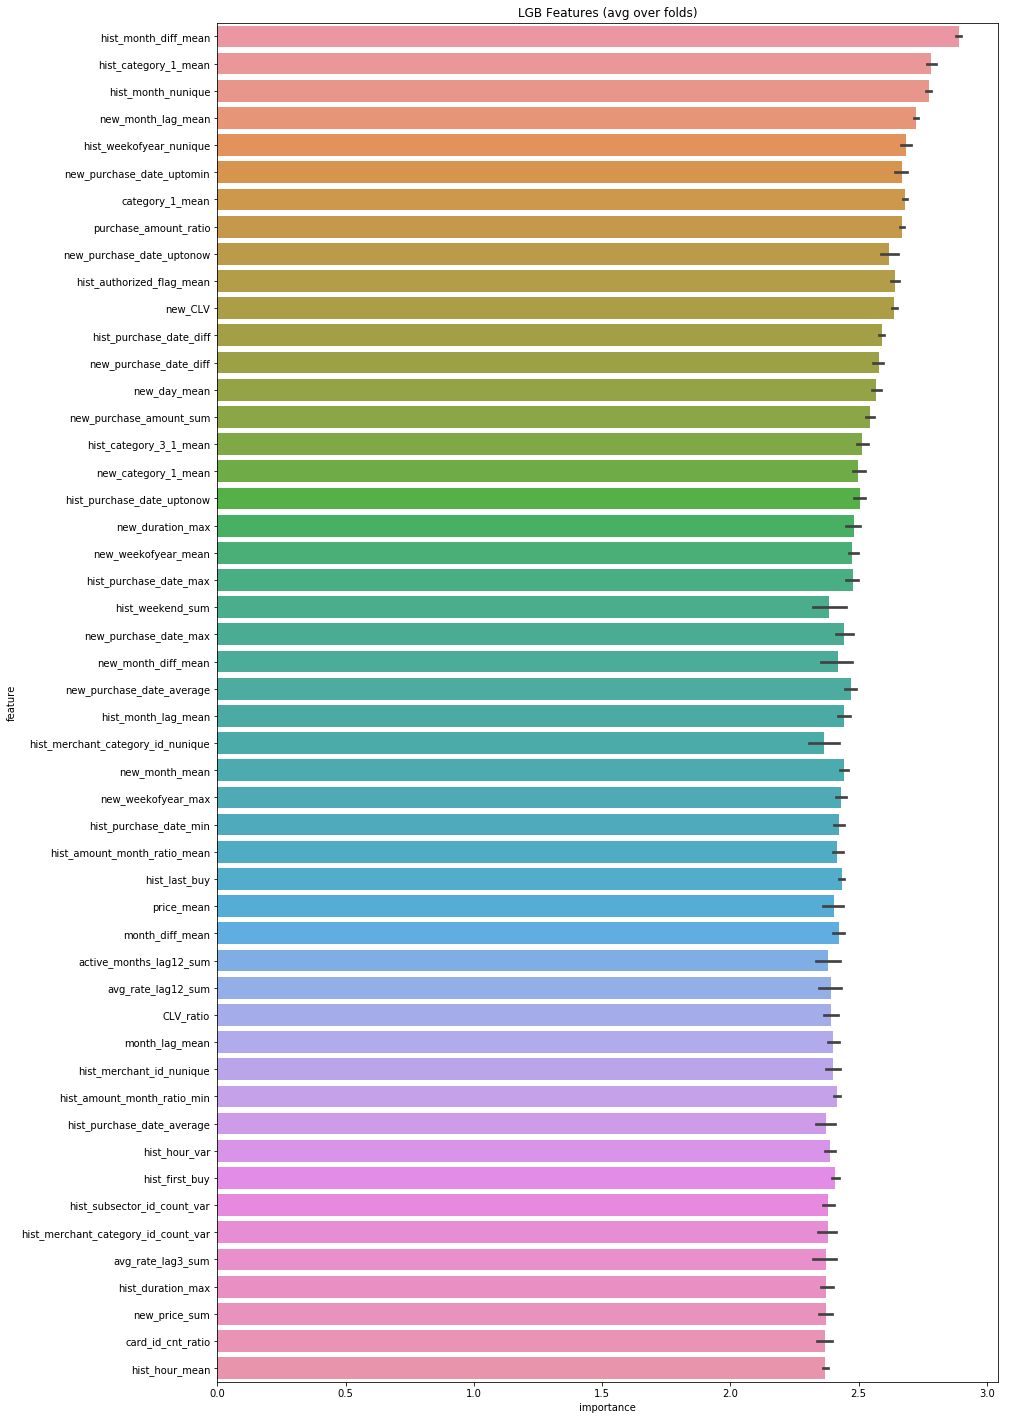

In [182]:
feature_importance['importance'] /= NFOLD
cols = feature_importance[['feature', 'importance']].groupby('feature').mean().sort_values(by='importance', ascending=False)[:50].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
best_features = best_features.sort_values(by='importance', ascending=False)

plt.figure(figsize=(14, 25))
plt.title('LGB Features (avg over folds)')
sns.barplot(x='importance', y='feature', data=best_features)
plt.show()

# feature extraction

In [755]:
import os
import gc
import sys
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from collections import defaultdict
from multiprocessing import cpu_count, Pool

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

import warnings
warnings.simplefilter('ignore')

In [756]:
PATH = os.path.join('..', 'remove_outlier_data')

KEY = 'card_id'
SEED = 6
NTHREAD = cpu_count()
NFOLD = 5

params = {
    'num_leaves': 31,
    'min_data_in_leaf': 30, 
    'objective':'regression',
    'max_depth': -1,
    'learning_rate': 0.01,
    'boosting': 'gbdt',
    'feature_fraction': 0.6,
    'bagging_freq': 1,
    'bagging_fraction': 0.8,
    'bagging_seed': 11,
    'metric': 'rmse',
    'lambda_l1': 0.1,
    'verbosity': -1,
    'nthread': NTHREAD,
    'random_state': SEED
}

features = []

features += [f'f10{i}.pkl' for i in (2, 3, 4, 5, 6, 7, 8)]
features += [f'f11{i}_{j}.pkl' for i in (1,) 
                               for j in ('Y', 'N')]
features += [f'f13{i}.pkl' for i in (1, 3, 4, 5)]

features += [f'f20{i}.pkl' for i in (2, 3, 4, 5, 6, 7, 8)]
features += [f'f23{i}.pkl' for i in (1, 5)]

features += [f'f30{i}.pkl' for i in (2, )]

In [757]:
train = pd.read_csv(os.path.join(PATH, 'train.csv'))
test = pd.read_csv(os.path.join(PATH, 'test.csv'))

for f in tqdm(features):
#     print(f)
    t = pd.read_pickle(os.path.join('..', 'remove_outlier_feature', f))
    train = pd.merge(train, t, on=KEY, how='left')
    test = pd.merge(test, t, on=KEY, how='left')

100%|██████████| 22/22 [00:28<00:00,  1.30s/it]


In [758]:
df = pd.concat([train, test], axis=0)
df['first_active_month'] = pd.to_datetime(df['first_active_month'])

date_features = [
    'hist_purchase_date_max','hist_purchase_date_min',
    'new_purchase_date_max', 'new_purchase_date_min',
    'Y_hist_auth_purchase_date_max', 'N_hist_auth_purchase_date_max',
    'Y_hist_auth_purchase_date_min', 'N_hist_auth_purchase_date_min'
]

for f in date_features:
    df[f] = pd.to_datetime(df[f])

df['hist_first_buy'] = (df['hist_purchase_date_min'].dt.date - df['first_active_month'].dt.date).dt.days
df['hist_last_buy'] = (df['hist_purchase_date_max'].dt.date - df['first_active_month'].dt.date).dt.days
df['new_first_buy'] = (df['new_purchase_date_min'].dt.date - df['first_active_month'].dt.date).dt.days
df['new_last_buy'] = (df['new_purchase_date_max'].dt.date - df['first_active_month'].dt.date).dt.days

for f in date_features:
    df[f] = df[f].astype(np.int64) * 1e-9

df['card_id_cnt_total'] = df['new_card_id_count'] + df['hist_card_id_count']
df['purchase_amount_total'] = df['new_purchase_amount_sum'] + df['hist_purchase_amount_sum']
df['purchase_amount_mean'] = df['new_purchase_amount_mean'] + df['hist_purchase_amount_mean']
df['purchase_amount_max'] = df['new_purchase_amount_max'] + df['hist_purchase_amount_max']
df['purchase_amount_min'] = df['new_purchase_amount_min'] + df['hist_purchase_amount_min']
df['sum_new_CLV'] = df['new_card_id_count'] * df['new_purchase_amount_sum'] / df['new_month_diff_mean']
df['sum_hist_CLV'] = df['hist_card_id_count'] * df['hist_purchase_amount_sum'] / df['hist_month_diff_mean']
df['sum_CLV_ratio'] = df['sum_new_CLV'] / df['sum_hist_CLV']

# df['outliers_1'] = df['hist_month_nunique'].apply(lambda x: np.where(x > 3, 1, 0))
# df['outliers_2'] = df['hist_month_diff_min'].apply(lambda x: np.where(x < 13, 1, 0))
# df['outliers_3'] = df['hist_month_diff_max'].apply(lambda x: np.where(x < 14, 1, 0))
# df['outliers_4'] = df['hist_month_lag_max'].apply(lambda x: np.where(x > -7, 1, 0))
# df['outliers_5'] = df['hist_month_lag_min'].apply(lambda x: np.where(x < -2, 1, 0))

# df['outliers_sum'] = df[['outliers_1', 'outliers_2', 'outliers_3', 'outliers_4', 'outliers_5']].apply(np.sum, axis=1)

categorical_features = [
    'feature_1', 'feature_2', 'feature_3',
]

# df['hist_subsector_id_nunique_x_hist_merchant_id_nunique '] = df['hist_subsector_id_nunique'] / df['hist_merchant_id_nunique']
# df['hist_merchant_id_nunique_x_hist_merchant_category_id_nunique'] = df['hist_merchant_id_nunique'] / df['hist_merchant_category_id_nunique']
# df['new_subsector_id_nunique_x_new_merchant_id_nunique '] = df['new_subsector_id_nunique'] / df['new_merchant_id_nunique']
# df['new_merchant_id_nunique_x_new_merchant_category_id_nunique'] = df['new_merchant_id_nunique'] / df['new_merchant_category_id_nunique']


for c in categorical_features:
    df[c] = df[c].astype('category')

df['nans'] = df.isnull().sum(axis=1)

train = df[df['target'].notnull()]
test = df[df['target'].isnull()]
y = train['target']

del df
gc.collect()

3196

# PCA

In [759]:
col_not_to_use = []

In [760]:
from sklearn.decomposition import PCA

In [761]:
categorical_features = ['feature_1', 'feature_2', 'feature_3']
pca = PCA(n_components=1)
pca.fit(train[categorical_features])
pca_train_values = pca.transform(train[categorical_features])
pca_test_values = pca.transform(test[categorical_features])

# col_not_to_use += ['feature_1', 'feature_2', 'feature_3']

pca_train_values = np.transpose(pca_train_values, (1, 0))
pca_test_values = np.transpose(pca_test_values, (1, 0))

for e, (pca_train, pca_test) in enumerate(zip(pca_train_values, pca_test_values)):
    train[f'pca_feature_{e}'] = pca_train
    test[f'pca_feature_{e}'] = pca_test

In [762]:
# features = ['feature_1_outliers_mean', 'feature_2_outliers_mean', 'feature_3_outliers_mean']
# pca = PCA(n_components=1)
# pca.fit(train[features])
# pca_train_values = pca.transform(train[features])
# pca_test_values = pca.transform(test[features])

# col_not_to_use += ['feature_1_outliers_mean', 'feature_2_outliers_mean', 'feature_3_outliers_mean']

# pca_train_values = np.transpose(pca_train_values, (1, 0))
# pca_test_values = np.transpose(pca_test_values, (1, 0))

# for e, (pca_train, pca_test) in enumerate(zip(pca_train_values, pca_test_values)):
#     train[f'pca_feature_outliers_mean_{e}'] = pca_train
#     test[f'pca_feature_outliers_mean_{e}'] = pca_test

In [763]:
# features = ['feature_1_outliers_sum', 'feature_2_outliers_sum', 'feature_3_outliers_sum']
# pca = PCA(n_components=1)
# pca.fit(train[features])
# pca_train_values = pca.transform(train[features])
# pca_test_values = pca.transform(test[features])

# col_not_to_use += ['feature_1_outliers_sum', 'feature_2_outliers_sum', 'feature_3_outliers_sum']

# pca_train_values = np.transpose(pca_train_values, (1, 0))
# pca_test_values = np.transpose(pca_test_values, (1, 0))

# for e, (pca_train, pca_test) in enumerate(zip(pca_train_values, pca_test_values)):
#     train[f'pca_feature_outliers_sum_{e}'] = pca_train
#     test[f'pca_feature_outliers_sum_{e}'] = pca_test

# exclude extra columns

In [764]:
col_not_to_use += [
    'first_active_month', 'card_id', 'target', 'outliers',
]

# col_not_to_use += [c for c in train.columns if ('duration' in c) or ('amount_month_ratio' in c) or ('skew' in c)]
col_to_use = [c for c in train.columns if c not in col_not_to_use]

gc.collect()

X_temp = train[col_to_use]
X_temp_test = test[col_to_use]

In [765]:
X_temp.shape

(201917, 625)

# CV

In [767]:
columns = X_temp.columns

In [768]:
columns = [c for c in columns if c not in use_columns]

In [769]:
folds = KFold(n_splits=4, shuffle=True, random_state=SEED)

pre_score = 10000
# use_columns = []

for c in columns:
    X = X_temp[use_columns + [c]]
    X_test = X_temp_test[use_columns + [c]]
    scores = []

    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        dtrain = lgb.Dataset(X.iloc[train_index], label=y.iloc[train_index])
        dvalid = lgb.Dataset(X.iloc[valid_index], label=y.iloc[valid_index])

        params = {
            'boosting': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'learning_rate': 0.01,
            'subsample': 0.9855232997390695,
            'max_depth': 7,
            'top_rate': 0.9064148448434349,
            'num_leaves': 63,
            'min_child_weight': 41.9612869171337,
            'other_rate': 0.0721768246018207,
            'reg_alpha': 9.677537745007898,
            'colsample_bytree': 0.5665320670155495,
            'min_split_gain': 9.820197773625843,
            'reg_lambda': 8.2532317400459,
            'min_data_in_leaf': 21,
            'verbose': -1,
            'seed':int(2**fold_n),
            'bagging_seed':int(2**fold_n),
            'drop_seed':int(2**fold_n)
        }

        model = lgb.train(
            params,
            dtrain,
            2000,          
            valid_sets=[dtrain, dvalid],
            verbose_eval=-1,
            early_stopping_rounds=200)

        y_pred_valid = model.predict(X.iloc[valid_index], num_iteration=model.best_iteration)
        scores.append(np.sqrt(mean_squared_error(y.iloc[valid_index], y_pred_valid)))

        del model
    
    if np.mean(scores) < pre_score:
        pre_score = np.mean(scores)
        use_columns.append(c)
    
    print('shape:', X.shape)
    print('CV {0:} mean score: {1:.4f}, std: {2:.4f}, max: {3:.4f}, min: {4:.4f}.'.format(4, np.mean(scores), np.std(scores), np.max(scores), np.min(scores)))

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1630]	training's rmse: 3.29243	valid_1's rmse: 3.54939
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[796]	training's rmse: 3.40477	valid_1's rmse: 3.65362
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1076]	training's rmse: 3.33448	valid_1's rmse: 3.71171
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[984]	training's rmse: 3.37111	valid_1's rmse: 3.65146
shape: (201917, 104)
CV 4 mean score: 3.6415, std: 0.0584, max: 3.7117, min: 3.5494.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1291]	training's rmse: 3.34204	valid_1's rmse: 3.54789
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[779]	training's rmse: 3.40653	valid_1's rmse: 3.

Early stopping, best iteration is:
[829]	training's rmse: 3.39934	valid_1's rmse: 3.65002
shape: (201917, 107)
CV 4 mean score: 3.6406, std: 0.0590, max: 3.7118, min: 3.5479.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1260]	training's rmse: 3.34802	valid_1's rmse: 3.54787
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[836]	training's rmse: 3.39719	valid_1's rmse: 3.65346
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[873]	training's rmse: 3.36962	valid_1's rmse: 3.71149
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1001]	training's rmse: 3.3694	valid_1's rmse: 3.65054
shape: (201917, 107)
CV 4 mean score: 3.6408, std: 0.0589, max: 3.7115, min: 3.5479.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[877]	training's rmse: 3.4158

Early stopping, best iteration is:
[1004]	training's rmse: 3.34298	valid_1's rmse: 3.71388
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1114]	training's rmse: 3.35013	valid_1's rmse: 3.65167
shape: (201917, 107)
CV 4 mean score: 3.6416, std: 0.0597, max: 3.7139, min: 3.5477.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1131]	training's rmse: 3.37098	valid_1's rmse: 3.54814
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[765]	training's rmse: 3.41074	valid_1's rmse: 3.6523
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[839]	training's rmse: 3.37511	valid_1's rmse: 3.71326
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[849]	training's rmse: 3.39532	valid_1's rmse: 3.65132
shape: (201917, 107)
CV 4 mean score: 3.6413, std: 0.0593,

Early stopping, best iteration is:
[791]	training's rmse: 3.40616	valid_1's rmse: 3.65232
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[937]	training's rmse: 3.3565	valid_1's rmse: 3.71219
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1111]	training's rmse: 3.34993	valid_1's rmse: 3.65121
shape: (201917, 107)
CV 4 mean score: 3.6411, std: 0.0588, max: 3.7122, min: 3.5487.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1338]	training's rmse: 3.33458	valid_1's rmse: 3.54786
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[790]	training's rmse: 3.40569	valid_1's rmse: 3.65371
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1046]	training's rmse: 3.34043	valid_1's rmse: 3.71165
Training until validation scores don't improve for 200 rou

Early stopping, best iteration is:
[1235]	training's rmse: 3.3499	valid_1's rmse: 3.54837
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[739]	training's rmse: 3.41374	valid_1's rmse: 3.65074
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[870]	training's rmse: 3.36775	valid_1's rmse: 3.71356
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[828]	training's rmse: 3.39672	valid_1's rmse: 3.65041
shape: (201917, 108)
CV 4 mean score: 3.6408, std: 0.0592, max: 3.7136, min: 3.5484.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1276]	training's rmse: 3.342	valid_1's rmse: 3.54822
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[786]	training's rmse: 3.40541	valid_1's rmse: 3.653
Training until validation scores don't improve for 200 rounds.


shape: (201917, 108)
CV 4 mean score: 3.6405, std: 0.0595, max: 3.7143, min: 3.5481.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1122]	training's rmse: 3.36914	valid_1's rmse: 3.54707
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[703]	training's rmse: 3.42084	valid_1's rmse: 3.65168
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1103]	training's rmse: 3.32923	valid_1's rmse: 3.71555
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[870]	training's rmse: 3.38929	valid_1's rmse: 3.64926
shape: (201917, 108)
CV 4 mean score: 3.6409, std: 0.0603, max: 3.7156, min: 3.5471.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1078]	training's rmse: 3.37587	valid_1's rmse: 3.54921
Training until validation scores don't improve for 200 rounds.

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[886]	training's rmse: 3.3867	valid_1's rmse: 3.64945
shape: (201917, 108)
CV 4 mean score: 3.6405, std: 0.0594, max: 3.7138, min: 3.5479.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1022]	training's rmse: 3.38672	valid_1's rmse: 3.55019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[735]	training's rmse: 3.41509	valid_1's rmse: 3.65209
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[965]	training's rmse: 3.35343	valid_1's rmse: 3.71375
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1020]	training's rmse: 3.36356	valid_1's rmse: 3.64858
shape: (201917, 108)
CV 4 mean score: 3.6412, std: 0.0586, max: 3.7137, min: 3.5502.
Training until validation scores don't improve for 200 rounds.
E

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1189]	training's rmse: 3.31379	valid_1's rmse: 3.71494
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[923]	training's rmse: 3.37973	valid_1's rmse: 3.65023
shape: (201917, 109)
CV 4 mean score: 3.6418, std: 0.0597, max: 3.7149, min: 3.5486.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1361]	training's rmse: 3.33288	valid_1's rmse: 3.54744
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[750]	training's rmse: 3.41192	valid_1's rmse: 3.65269
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[983]	training's rmse: 3.34931	valid_1's rmse: 3.71456
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[918]	training's rmse: 3.38218	valid_1's rmse: 3.6

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[748]	training's rmse: 3.4114	valid_1's rmse: 3.65263
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[998]	training's rmse: 3.34691	valid_1's rmse: 3.71508
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[916]	training's rmse: 3.38398	valid_1's rmse: 3.65115
shape: (201917, 109)
CV 4 mean score: 3.6419, std: 0.0596, max: 3.7151, min: 3.5489.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1414]	training's rmse: 3.32673	valid_1's rmse: 3.54931
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[871]	training's rmse: 3.38913	valid_1's rmse: 3.65279
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1087]	training's rmse: 3.3329	valid_1's rmse: 3.712

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1222]	training's rmse: 3.35448	valid_1's rmse: 3.54885
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[820]	training's rmse: 3.39841	valid_1's rmse: 3.6545
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[772]	training's rmse: 3.38432	valid_1's rmse: 3.71404
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1237]	training's rmse: 3.32729	valid_1's rmse: 3.65094
shape: (201917, 109)
CV 4 mean score: 3.6421, std: 0.0594, max: 3.7140, min: 3.5488.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1109]	training's rmse: 3.37176	valid_1's rmse: 3.54928
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1199]	training's rmse: 3.33884	valid_1's rmse: 3.

Early stopping, best iteration is:
[913]	training's rmse: 3.38327	valid_1's rmse: 3.65119
shape: (201917, 109)
CV 4 mean score: 3.6420, std: 0.0593, max: 3.7146, min: 3.5494.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1514]	training's rmse: 3.3067	valid_1's rmse: 3.54699
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[895]	training's rmse: 3.38654	valid_1's rmse: 3.65108
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[964]	training's rmse: 3.35321	valid_1's rmse: 3.71446
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[941]	training's rmse: 3.3764	valid_1's rmse: 3.64855
shape: (201917, 109)
CV 4 mean score: 3.6403, std: 0.0600, max: 3.7145, min: 3.5470.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1263]	training's rmse: 3.34809

Early stopping, best iteration is:
[776]	training's rmse: 3.38431	valid_1's rmse: 3.7147
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[973]	training's rmse: 3.37034	valid_1's rmse: 3.64995
shape: (201917, 109)
CV 4 mean score: 3.6418, std: 0.0593, max: 3.7147, min: 3.5493.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1182]	training's rmse: 3.35993	valid_1's rmse: 3.54912
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[781]	training's rmse: 3.40603	valid_1's rmse: 3.65292
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1130]	training's rmse: 3.32526	valid_1's rmse: 3.71395
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[936]	training's rmse: 3.38019	valid_1's rmse: 3.65086
shape: (201917, 109)
CV 4 mean score: 3.6417, std: 0.0592, 

Early stopping, best iteration is:
[798]	training's rmse: 3.40378	valid_1's rmse: 3.65227
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[816]	training's rmse: 3.38173	valid_1's rmse: 3.71355
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[897]	training's rmse: 3.38832	valid_1's rmse: 3.65158
shape: (201917, 109)
CV 4 mean score: 3.6416, std: 0.0591, max: 3.7136, min: 3.5490.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1354]	training's rmse: 3.33379	valid_1's rmse: 3.54822
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[812]	training's rmse: 3.40038	valid_1's rmse: 3.65376
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[829]	training's rmse: 3.37676	valid_1's rmse: 3.71406
Training until validation scores don't improve for 200 roun

Early stopping, best iteration is:
[1256]	training's rmse: 3.34911	valid_1's rmse: 3.54855
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[789]	training's rmse: 3.4027	valid_1's rmse: 3.65345
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1119]	training's rmse: 3.32506	valid_1's rmse: 3.71373
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1161]	training's rmse: 3.33782	valid_1's rmse: 3.65125
shape: (201917, 109)
CV 4 mean score: 3.6417, std: 0.0594, max: 3.7137, min: 3.5486.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1128]	training's rmse: 3.36881	valid_1's rmse: 3.54949
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[687]	training's rmse: 3.42047	valid_1's rmse: 3.65499
Training until validation scores don't improve for 200 ro

shape: (201917, 109)
CV 4 mean score: 3.6421, std: 0.0598, max: 3.7143, min: 3.5479.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1223]	training's rmse: 3.35389	valid_1's rmse: 3.55029
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[821]	training's rmse: 3.39807	valid_1's rmse: 3.65341
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[952]	training's rmse: 3.35626	valid_1's rmse: 3.71402
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1020]	training's rmse: 3.36242	valid_1's rmse: 3.64991
shape: (201917, 109)
CV 4 mean score: 3.6419, std: 0.0587, max: 3.7140, min: 3.5503.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1065]	training's rmse: 3.38114	valid_1's rmse: 3.54908
Training until validation scores don't improve for 200 rounds.

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1024]	training's rmse: 3.35723	valid_1's rmse: 3.65083
shape: (201917, 109)
CV 4 mean score: 3.6420, std: 0.0592, max: 3.7156, min: 3.5500.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1340]	training's rmse: 3.33782	valid_1's rmse: 3.54961
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[666]	training's rmse: 3.42489	valid_1's rmse: 3.65465
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1205]	training's rmse: 3.31188	valid_1's rmse: 3.71378
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1048]	training's rmse: 3.36011	valid_1's rmse: 3.65051
shape: (201917, 109)
CV 4 mean score: 3.6421, std: 0.0590, max: 3.7138, min: 3.5496.
Training until validation scores don't improve for 200 rounds

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[996]	training's rmse: 3.35112	valid_1's rmse: 3.71473
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1197]	training's rmse: 3.33567	valid_1's rmse: 3.64974
shape: (201917, 109)
CV 4 mean score: 3.6414, std: 0.0590, max: 3.7147, min: 3.5498.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1360]	training's rmse: 3.331	valid_1's rmse: 3.54893
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[705]	training's rmse: 3.41892	valid_1's rmse: 3.65353
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1032]	training's rmse: 3.33805	valid_1's rmse: 3.71612
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1235]	training's rmse: 3.32599	valid_1's rmse: 3.6

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[899]	training's rmse: 3.38593	valid_1's rmse: 3.65127
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1041]	training's rmse: 3.34062	valid_1's rmse: 3.71396
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1273]	training's rmse: 3.32192	valid_1's rmse: 3.64837
shape: (201917, 109)
CV 4 mean score: 3.6412, std: 0.0581, max: 3.7140, min: 3.5514.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1085]	training's rmse: 3.37767	valid_1's rmse: 3.54801
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[761]	training's rmse: 3.40874	valid_1's rmse: 3.65402
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1081]	training's rmse: 3.33176	valid_1's rmse: 3

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1055]	training's rmse: 3.38125	valid_1's rmse: 3.54998
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[787]	training's rmse: 3.40063	valid_1's rmse: 3.65182
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[940]	training's rmse: 3.35547	valid_1's rmse: 3.71421
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[956]	training's rmse: 3.37367	valid_1's rmse: 3.65246
shape: (201917, 109)
CV 4 mean score: 3.6421, std: 0.0589, max: 3.7142, min: 3.5500.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1443]	training's rmse: 3.31859	valid_1's rmse: 3.54928
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[794]	training's rmse: 3.40293	valid_1's rmse: 3.6

Early stopping, best iteration is:
[1269]	training's rmse: 3.32204	valid_1's rmse: 3.65035
shape: (201917, 109)
CV 4 mean score: 3.6421, std: 0.0597, max: 3.7147, min: 3.5486.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[995]	training's rmse: 3.39187	valid_1's rmse: 3.55059
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[767]	training's rmse: 3.407	valid_1's rmse: 3.65247
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[890]	training's rmse: 3.36755	valid_1's rmse: 3.71435
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[948]	training's rmse: 3.37753	valid_1's rmse: 3.65057
shape: (201917, 109)
CV 4 mean score: 3.6420, std: 0.0587, max: 3.7144, min: 3.5506.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1650]	training's rmse: 3.28913

Early stopping, best iteration is:
[997]	training's rmse: 3.34735	valid_1's rmse: 3.71357
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1118]	training's rmse: 3.34593	valid_1's rmse: 3.64911
shape: (201917, 109)
CV 4 mean score: 3.6411, std: 0.0591, max: 3.7136, min: 3.5489.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1215]	training's rmse: 3.35301	valid_1's rmse: 3.54693
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[847]	training's rmse: 3.39131	valid_1's rmse: 3.65298
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1222]	training's rmse: 3.30308	valid_1's rmse: 3.71643
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[988]	training's rmse: 3.36501	valid_1's rmse: 3.64997
shape: (201917, 109)
CV 4 mean score: 3.6416, std: 0.0607

Early stopping, best iteration is:
[740]	training's rmse: 3.40949	valid_1's rmse: 3.65297
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[928]	training's rmse: 3.36072	valid_1's rmse: 3.71501
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1159]	training's rmse: 3.3427	valid_1's rmse: 3.6499
shape: (201917, 109)
CV 4 mean score: 3.6424, std: 0.0585, max: 3.7150, min: 3.5517.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[995]	training's rmse: 3.39383	valid_1's rmse: 3.54898
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[804]	training's rmse: 3.40142	valid_1's rmse: 3.65463
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1264]	training's rmse: 3.30265	valid_1's rmse: 3.71377
Training until validation scores don't improve for 200 round

Early stopping, best iteration is:
[1036]	training's rmse: 3.38866	valid_1's rmse: 3.55054
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[831]	training's rmse: 3.39859	valid_1's rmse: 3.65271
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1302]	training's rmse: 3.30147	valid_1's rmse: 3.71355
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1107]	training's rmse: 3.35036	valid_1's rmse: 3.65008
shape: (201917, 109)
CV 4 mean score: 3.6417, std: 0.0584, max: 3.7136, min: 3.5505.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1414]	training's rmse: 3.32603	valid_1's rmse: 3.54886
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[748]	training's rmse: 3.41009	valid_1's rmse: 3.65401
Training until validation scores don't improve for 200 r

shape: (201917, 109)
CV 4 mean score: 3.6410, std: 0.0590, max: 3.7141, min: 3.5494.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1223]	training's rmse: 3.35449	valid_1's rmse: 3.5471
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[758]	training's rmse: 3.40738	valid_1's rmse: 3.65236
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1011]	training's rmse: 3.34508	valid_1's rmse: 3.7129
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1028]	training's rmse: 3.3611	valid_1's rmse: 3.6505
shape: (201917, 109)
CV 4 mean score: 3.6407, std: 0.0596, max: 3.7129, min: 3.5471.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1518]	training's rmse: 3.31239	valid_1's rmse: 3.54949
Training until validation scores don't improve for 200 rounds.
Ea

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[887]	training's rmse: 3.38758	valid_1's rmse: 3.65095
shape: (201917, 109)
CV 4 mean score: 3.6417, std: 0.0597, max: 3.7139, min: 3.5478.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1162]	training's rmse: 3.367	valid_1's rmse: 3.5496
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[857]	training's rmse: 3.39187	valid_1's rmse: 3.65306
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1027]	training's rmse: 3.34594	valid_1's rmse: 3.71311
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[810]	training's rmse: 3.40421	valid_1's rmse: 3.6496
shape: (201917, 109)
CV 4 mean score: 3.6413, std: 0.0587, max: 3.7131, min: 3.5496.
Training until validation scores don't improve for 200 rounds.
Earl

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1148]	training's rmse: 3.3274	valid_1's rmse: 3.71377
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1106]	training's rmse: 3.35264	valid_1's rmse: 3.6484
shape: (201917, 109)
CV 4 mean score: 3.6413, std: 0.0591, max: 3.7138, min: 3.5490.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1416]	training's rmse: 3.32732	valid_1's rmse: 3.54894
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[756]	training's rmse: 3.41215	valid_1's rmse: 3.65339
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[938]	training's rmse: 3.3566	valid_1's rmse: 3.7147
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1173]	training's rmse: 3.33829	valid_1's rmse: 3.650

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[897]	training's rmse: 3.38592	valid_1's rmse: 3.65259
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1045]	training's rmse: 3.34071	valid_1's rmse: 3.71519
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[840]	training's rmse: 3.39597	valid_1's rmse: 3.6516
shape: (201917, 109)
CV 4 mean score: 3.6420, std: 0.0598, max: 3.7152, min: 3.5485.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1275]	training's rmse: 3.35041	valid_1's rmse: 3.54929
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[703]	training's rmse: 3.42092	valid_1's rmse: 3.65329
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[933]	training's rmse: 3.3601	valid_1's rmse: 3.713

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1229]	training's rmse: 3.35101	valid_1's rmse: 3.5487
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[767]	training's rmse: 3.40903	valid_1's rmse: 3.65479
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1023]	training's rmse: 3.34392	valid_1's rmse: 3.71412
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1106]	training's rmse: 3.34997	valid_1's rmse: 3.65026
shape: (201917, 109)
CV 4 mean score: 3.6420, std: 0.0595, max: 3.7141, min: 3.5487.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1607]	training's rmse: 3.29737	valid_1's rmse: 3.54963
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[742]	training's rmse: 3.41023	valid_1's rmse: 3.

Early stopping, best iteration is:
[883]	training's rmse: 3.38661	valid_1's rmse: 3.64943
shape: (201917, 109)
CV 4 mean score: 3.6413, std: 0.0592, max: 3.7136, min: 3.5487.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1144]	training's rmse: 3.36792	valid_1's rmse: 3.54827
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[880]	training's rmse: 3.38743	valid_1's rmse: 3.654
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[798]	training's rmse: 3.38152	valid_1's rmse: 3.7149
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[999]	training's rmse: 3.37102	valid_1's rmse: 3.65063
shape: (201917, 109)
CV 4 mean score: 3.6420, std: 0.0598, max: 3.7149, min: 3.5483.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1223]	training's rmse: 3.353	va

Early stopping, best iteration is:
[997]	training's rmse: 3.34833	valid_1's rmse: 3.7137
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[857]	training's rmse: 3.39536	valid_1's rmse: 3.65062
shape: (201917, 109)
CV 4 mean score: 3.6421, std: 0.0591, max: 3.7137, min: 3.5492.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1444]	training's rmse: 3.32155	valid_1's rmse: 3.54803
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[691]	training's rmse: 3.4214	valid_1's rmse: 3.65398
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[802]	training's rmse: 3.38006	valid_1's rmse: 3.71462
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1161]	training's rmse: 3.34331	valid_1's rmse: 3.64924
shape: (201917, 109)
CV 4 mean score: 3.6415, std: 0.0598, m

Early stopping, best iteration is:
[749]	training's rmse: 3.41226	valid_1's rmse: 3.65422
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1087]	training's rmse: 3.3329	valid_1's rmse: 3.71289
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1047]	training's rmse: 3.36174	valid_1's rmse: 3.64931
shape: (201917, 109)
CV 4 mean score: 3.6414, std: 0.0588, max: 3.7129, min: 3.5492.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1498]	training's rmse: 3.31533	valid_1's rmse: 3.54823
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[661]	training's rmse: 3.42574	valid_1's rmse: 3.65363
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1033]	training's rmse: 3.34336	valid_1's rmse: 3.71405
Training until validation scores don't improve for 200 ro

Early stopping, best iteration is:
[1059]	training's rmse: 3.38126	valid_1's rmse: 3.55077
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[864]	training's rmse: 3.39153	valid_1's rmse: 3.6538
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[937]	training's rmse: 3.35921	valid_1's rmse: 3.71449
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[968]	training's rmse: 3.37287	valid_1's rmse: 3.64989
shape: (201917, 109)
CV 4 mean score: 3.6422, std: 0.0587, max: 3.7145, min: 3.5508.
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 3.24232	valid_1's rmse: 3.54688
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[804]	training's rmse: 3.401	valid_1's rmse: 3.65183
Training until validation scores don't improve f

shape: (201917, 111)
CV 4 mean score: 3.6397, std: 0.0608, max: 3.7138, min: 3.5446.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1230]	training's rmse: 3.35021	valid_1's rmse: 3.54486
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[799]	training's rmse: 3.39724	valid_1's rmse: 3.64956
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[847]	training's rmse: 3.37208	valid_1's rmse: 3.71453
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[836]	training's rmse: 3.3932	valid_1's rmse: 3.64913
shape: (201917, 111)
CV 4 mean score: 3.6395, std: 0.0608, max: 3.7145, min: 3.5449.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1507]	training's rmse: 3.31056	valid_1's rmse: 3.54415
Training until validation scores don't improve for 200 rounds.
E

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[719]	training's rmse: 3.41515	valid_1's rmse: 3.64916
shape: (201917, 111)
CV 4 mean score: 3.6393, std: 0.0610, max: 3.7144, min: 3.5441.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1142]	training's rmse: 3.36844	valid_1's rmse: 3.54566
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[833]	training's rmse: 3.39203	valid_1's rmse: 3.6495
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[849]	training's rmse: 3.37142	valid_1's rmse: 3.71501
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[879]	training's rmse: 3.38802	valid_1's rmse: 3.6495
shape: (201917, 111)
CV 4 mean score: 3.6399, std: 0.0606, max: 3.7150, min: 3.5457.
Training until validation scores don't improve for 200 rounds.
Ear

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[987]	training's rmse: 3.34822	valid_1's rmse: 3.71488
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1023]	training's rmse: 3.36149	valid_1's rmse: 3.64821
shape: (201917, 111)
CV 4 mean score: 3.6389, std: 0.0614, max: 3.7149, min: 3.5435.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1121]	training's rmse: 3.36945	valid_1's rmse: 3.543
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[874]	training's rmse: 3.38226	valid_1's rmse: 3.64894
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[969]	training's rmse: 3.3525	valid_1's rmse: 3.71481
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[912]	training's rmse: 3.38107	valid_1's rmse: 3.6488

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[957]	training's rmse: 3.36904	valid_1's rmse: 3.64905
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[996]	training's rmse: 3.34506	valid_1's rmse: 3.71506
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[948]	training's rmse: 3.37401	valid_1's rmse: 3.64924
shape: (201917, 111)
CV 4 mean score: 3.6392, std: 0.0615, max: 3.7151, min: 3.5435.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1452]	training's rmse: 3.3205	valid_1's rmse: 3.54486
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[871]	training's rmse: 3.38389	valid_1's rmse: 3.65003
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[746]	training's rmse: 3.38776	valid_1's rmse: 3.717

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1304]	training's rmse: 3.33844	valid_1's rmse: 3.54471
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1261]	training's rmse: 3.32315	valid_1's rmse: 3.64919
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1056]	training's rmse: 3.33705	valid_1's rmse: 3.71496
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[916]	training's rmse: 3.37692	valid_1's rmse: 3.64951
shape: (201917, 111)
CV 4 mean score: 3.6396, std: 0.0610, max: 3.7150, min: 3.5447.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1007]	training's rmse: 3.38967	valid_1's rmse: 3.54508
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[816]	training's rmse: 3.3918	valid_1's rmse: 3.

Early stopping, best iteration is:
[922]	training's rmse: 3.37773	valid_1's rmse: 3.64987
shape: (201917, 111)
CV 4 mean score: 3.6394, std: 0.0608, max: 3.7133, min: 3.5440.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1341]	training's rmse: 3.33563	valid_1's rmse: 3.54385
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[795]	training's rmse: 3.39821	valid_1's rmse: 3.64863
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[981]	training's rmse: 3.34885	valid_1's rmse: 3.71429
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[822]	training's rmse: 3.39748	valid_1's rmse: 3.64973
shape: (201917, 111)
CV 4 mean score: 3.6391, std: 0.0611, max: 3.7143, min: 3.5438.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1240]	training's rmse: 3.352

Early stopping, best iteration is:
[1038]	training's rmse: 3.33663	valid_1's rmse: 3.71312
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[887]	training's rmse: 3.38453	valid_1's rmse: 3.6489
shape: (201917, 111)
CV 4 mean score: 3.6393, std: 0.0607, max: 3.7131, min: 3.5442.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1047]	training's rmse: 3.38228	valid_1's rmse: 3.54591
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[879]	training's rmse: 3.38572	valid_1's rmse: 3.64942
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[982]	training's rmse: 3.34711	valid_1's rmse: 3.71383
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1195]	training's rmse: 3.33085	valid_1's rmse: 3.64991
shape: (201917, 111)
CV 4 mean score: 3.6398, std: 0.0602,

Early stopping, best iteration is:
[805]	training's rmse: 3.39335	valid_1's rmse: 3.64975
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1051]	training's rmse: 3.33577	valid_1's rmse: 3.71297
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[871]	training's rmse: 3.38668	valid_1's rmse: 3.64947
shape: (201917, 111)
CV 4 mean score: 3.6391, std: 0.0605, max: 3.7130, min: 3.5443.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1181]	training's rmse: 3.35793	valid_1's rmse: 3.54528
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[938]	training's rmse: 3.37365	valid_1's rmse: 3.64868
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1071]	training's rmse: 3.3334	valid_1's rmse: 3.7136
Training until validation scores don't improve for 200 roun

Early stopping, best iteration is:
[1084]	training's rmse: 3.37708	valid_1's rmse: 3.54414
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[899]	training's rmse: 3.37898	valid_1's rmse: 3.64827
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1150]	training's rmse: 3.31846	valid_1's rmse: 3.7135
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[892]	training's rmse: 3.38345	valid_1's rmse: 3.64863
shape: (201917, 111)
CV 4 mean score: 3.6386, std: 0.0607, max: 3.7135, min: 3.5441.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1101]	training's rmse: 3.37521	valid_1's rmse: 3.54493
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[870]	training's rmse: 3.38528	valid_1's rmse: 3.65145
Training until validation scores don't improve for 200 rou

shape: (201917, 111)
CV 4 mean score: 3.6395, std: 0.0602, max: 3.7139, min: 3.5458.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1034]	training's rmse: 3.38549	valid_1's rmse: 3.54388
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[812]	training's rmse: 3.39426	valid_1's rmse: 3.64951
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1015]	training's rmse: 3.34075	valid_1's rmse: 3.71482
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[872]	training's rmse: 3.38737	valid_1's rmse: 3.64955
shape: (201917, 111)
CV 4 mean score: 3.6394, std: 0.0613, max: 3.7148, min: 3.5439.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1484]	training's rmse: 3.31333	valid_1's rmse: 3.54463
Training until validation scores don't improve for 200 rounds.

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1173]	training's rmse: 3.33414	valid_1's rmse: 3.64884
shape: (201917, 111)
CV 4 mean score: 3.6394, std: 0.0613, max: 3.7147, min: 3.5437.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1165]	training's rmse: 3.36217	valid_1's rmse: 3.5444
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[959]	training's rmse: 3.36976	valid_1's rmse: 3.65055
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[976]	training's rmse: 3.34992	valid_1's rmse: 3.71442
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[881]	training's rmse: 3.38569	valid_1's rmse: 3.64917
shape: (201917, 111)
CV 4 mean score: 3.6396, std: 0.0610, max: 3.7144, min: 3.5444.
Training until validation scores don't improve for 200 rounds.
E

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[731]	training's rmse: 3.39042	valid_1's rmse: 3.71535
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[794]	training's rmse: 3.40064	valid_1's rmse: 3.64969
shape: (201917, 111)
CV 4 mean score: 3.6401, std: 0.0605, max: 3.7154, min: 3.5463.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1637]	training's rmse: 3.29057	valid_1's rmse: 3.54429
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1046]	training's rmse: 3.35692	valid_1's rmse: 3.64943
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1106]	training's rmse: 3.32456	valid_1's rmse: 3.71497
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1105]	training's rmse: 3.34238	valid_1's rmse: 3

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[975]	training's rmse: 3.3666	valid_1's rmse: 3.64949
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1062]	training's rmse: 3.33172	valid_1's rmse: 3.71532
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[869]	training's rmse: 3.38721	valid_1's rmse: 3.64851
shape: (201917, 111)
CV 4 mean score: 3.6399, std: 0.0605, max: 3.7153, min: 3.5461.
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1401]	training's rmse: 3.3249	valid_1's rmse: 3.54347
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[687]	training's rmse: 3.41947	valid_1's rmse: 3.64932
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1043]	training's rmse: 3.33732	valid_1's rmse: 3.71

In [742]:
use_columns

['feature_1',
 'feature_2',
 'elapsed_time',
 'feature_1_outliers_mean',
 'feature_1_outliers_sum',
 'feature_2_outliers_mean',
 'hist_subsector_id_nunique',
 'hist_year_nunique',
 'hist_month_nunique',
 'hist_month_mean',
 'hist_month_min',
 'hist_month_max',
 'hist_hour_nunique',
 'hist_hour_min',
 'hist_hour_max',
 'hist_weekofyear_nunique',
 'hist_weekofyear_min',
 'hist_day_nunique',
 'hist_weekday_mean',
 'hist_weekday_min',
 'hist_weekday_max',
 'hist_purchase_amount_sum',
 'hist_purchase_amount_min',
 'hist_purchase_amount_mean',
 'hist_installments_sum',
 'hist_installments_max',
 'feature_3',
 'feature_2_outliers_sum',
 'hist_merchant_id_nunique',
 'hist_purchase_amount_skew',
 'hist_purchase_date_max',
 'hist_month_lag_max',
 'hist_month_lag_min',
 'hist_month_lag_mean',
 'hist_month_diff_mean',
 'hist_month_diff_std',
 'hist_authorized_flag_sum',
 'hist_authorized_flag_mean',
 'hist_authorized_flag_std',
 'hist_authorized_flag_skew',
 'hist_category_1_mean',
 'hist_category

In [773]:
use_columns

['feature_1',
 'feature_2',
 'elapsed_time',
 'feature_1_outliers_mean',
 'feature_1_outliers_sum',
 'feature_2_outliers_mean',
 'hist_subsector_id_nunique',
 'hist_year_nunique',
 'hist_month_nunique',
 'hist_month_mean',
 'hist_month_min',
 'hist_month_max',
 'hist_hour_nunique',
 'hist_hour_min',
 'hist_hour_max',
 'hist_weekofyear_nunique',
 'hist_weekofyear_min',
 'hist_day_nunique',
 'hist_weekday_mean',
 'hist_weekday_min',
 'hist_weekday_max',
 'hist_purchase_amount_sum',
 'hist_purchase_amount_min',
 'hist_purchase_amount_mean',
 'hist_installments_sum',
 'hist_installments_max',
 'feature_3',
 'feature_2_outliers_sum',
 'hist_merchant_id_nunique',
 'hist_purchase_amount_skew',
 'hist_purchase_date_max',
 'hist_month_lag_max',
 'hist_month_lag_min',
 'hist_month_lag_mean',
 'hist_month_diff_mean',
 'hist_month_diff_std',
 'hist_authorized_flag_sum',
 'hist_authorized_flag_mean',
 'hist_authorized_flag_std',
 'hist_authorized_flag_skew',
 'hist_category_1_mean',
 'hist_category

In [770]:
folds = KFold(n_splits=11, shuffle=True, random_state=SEED)

X = X_temp[use_columns]
X_test = X_temp_test[use_columns]
scores = []
prediction = np.zeros(len(X_test))

for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
    dtrain = lgb.Dataset(X.iloc[train_index], label=y.iloc[train_index])
    dvalid = lgb.Dataset(X.iloc[valid_index], label=y.iloc[valid_index])

    params = {
        'boosting': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.01,
        'subsample': 0.9855232997390695,
        'max_depth': 7,
        'top_rate': 0.9064148448434349,
        'num_leaves': 63,
        'min_child_weight': 41.9612869171337,
        'other_rate': 0.0721768246018207,
        'reg_alpha': 9.677537745007898,
        'colsample_bytree': 0.5665320670155495,
        'min_split_gain': 9.820197773625843,
        'reg_lambda': 8.2532317400459,
        'min_data_in_leaf': 21,
        'verbose': -1,
        'seed':int(2**fold_n),
        'bagging_seed':int(2**fold_n),
        'drop_seed':int(2**fold_n)
    }

    model = lgb.train(
        params,
        dtrain,
        2000,          
        valid_sets=[dtrain, dvalid],
        verbose_eval=-1,
        early_stopping_rounds=200)


    y_pred_valid = model.predict(X.iloc[valid_index], num_iteration=model.best_iteration)
    scores.append(np.sqrt(mean_squared_error(y.iloc[valid_index], y_pred_valid)))

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    prediction += y_pred / folds.n_splits   

    del model

print('shape:', X.shape)
print('CV {0:} mean score: {1:.4f}, std: {2:.4f}, max: {3:.4f}, min: {4:.4f}.'.format(4, np.mean(scores), np.std(scores), np.max(scores), np.min(scores)))

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1283]	training's rmse: 3.3595	valid_1's rmse: 3.58537
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1257]	training's rmse: 3.36297	valid_1's rmse: 3.54179
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1482]	training's rmse: 3.33398	valid_1's rmse: 3.58547
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[876]	training's rmse: 3.4039	valid_1's rmse: 3.7821
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[919]	training's rmse: 3.42446	valid_1's rmse: 3.50307
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[773]	training's rmse: 3.42707	valid_1's rmse: 3.67807
Training until validation scores don't improve for 200 rounds.
Early stopping, bes

In [771]:
submission = pd.read_csv(os.path.join('..', 'input', 'sample_submission.csv'))
submission['target'] = prediction
submission.to_csv(os.path.join('..', 'submission', 'lightgbm_outlier_{}.csv'.format(str(datetime.datetime.today().date()).replace('-', ''))), index=False)

In [772]:
pd.DataFrame(use_columns, columns=['columns']).to_csv('use_cols2.csv', index=False)

# feature importance

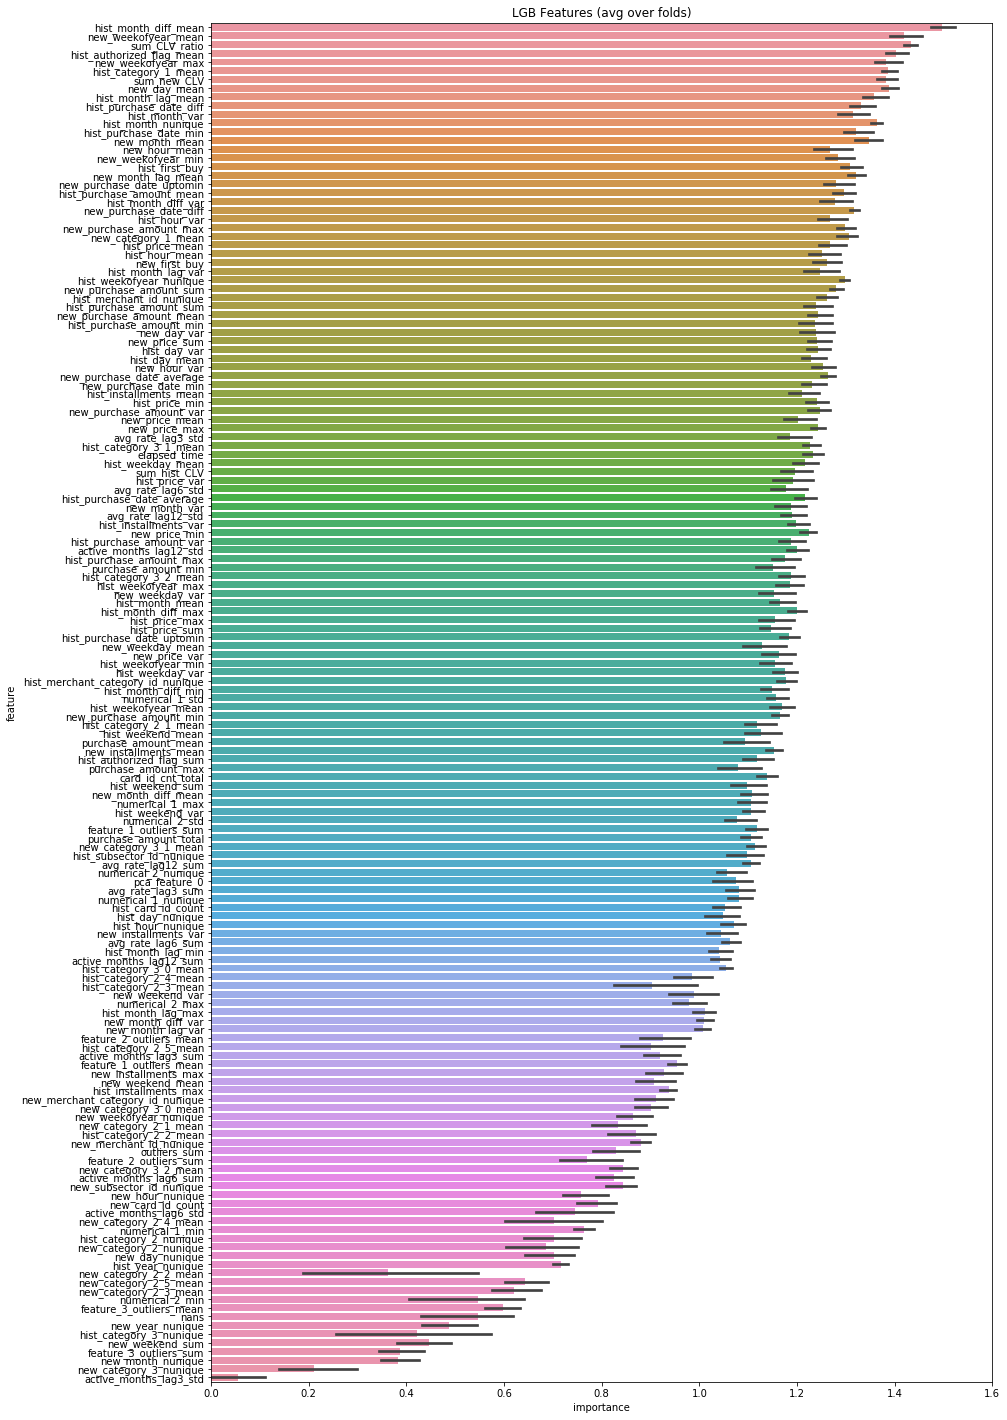

In [482]:
feature_importance['importance'] /= NFOLD
cols = feature_importance[['feature', 'importance']].groupby('feature').mean().sort_values(by='importance', ascending=False)[:200].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
best_features = best_features.sort_values(by='importance', ascending=False)

plt.figure(figsize=(14, 25))
plt.title('LGB Features (avg over folds)')
sns.barplot(x='importance', y='feature', data=best_features)
plt.show()

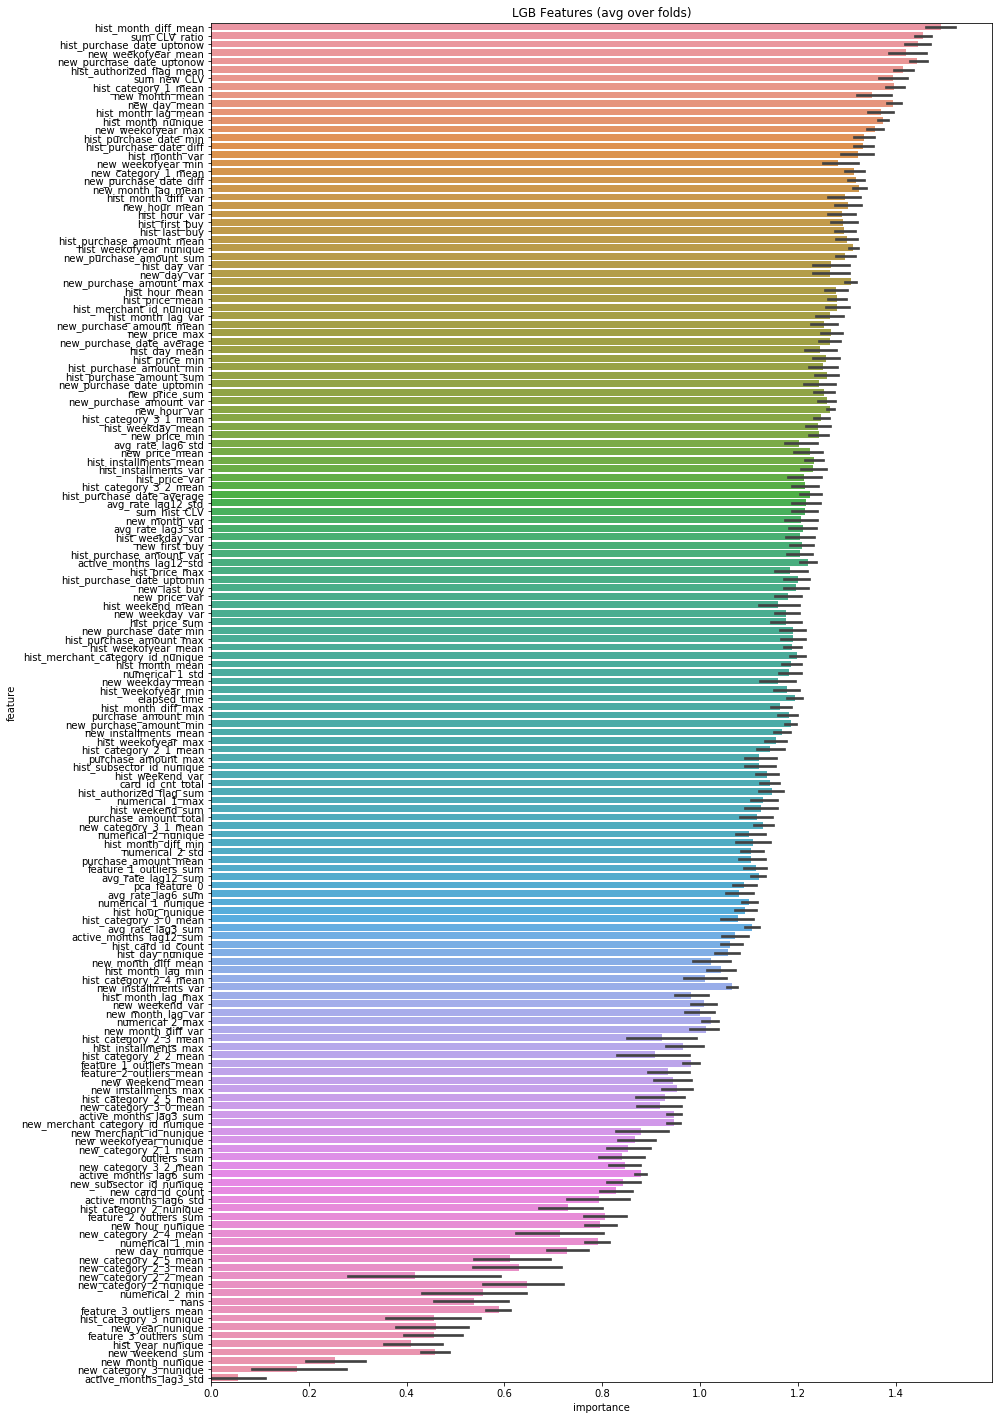

In [456]:
feature_importance['importance'] /= NFOLD
cols = feature_importance[['feature', 'importance']].groupby('feature').mean().sort_values(by='importance', ascending=False)[:200].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
best_features = best_features.sort_values(by='importance', ascending=False)

plt.figure(figsize=(14, 25))
plt.title('LGB Features (avg over folds)')
sns.barplot(x='importance', y='feature', data=best_features)
plt.show()

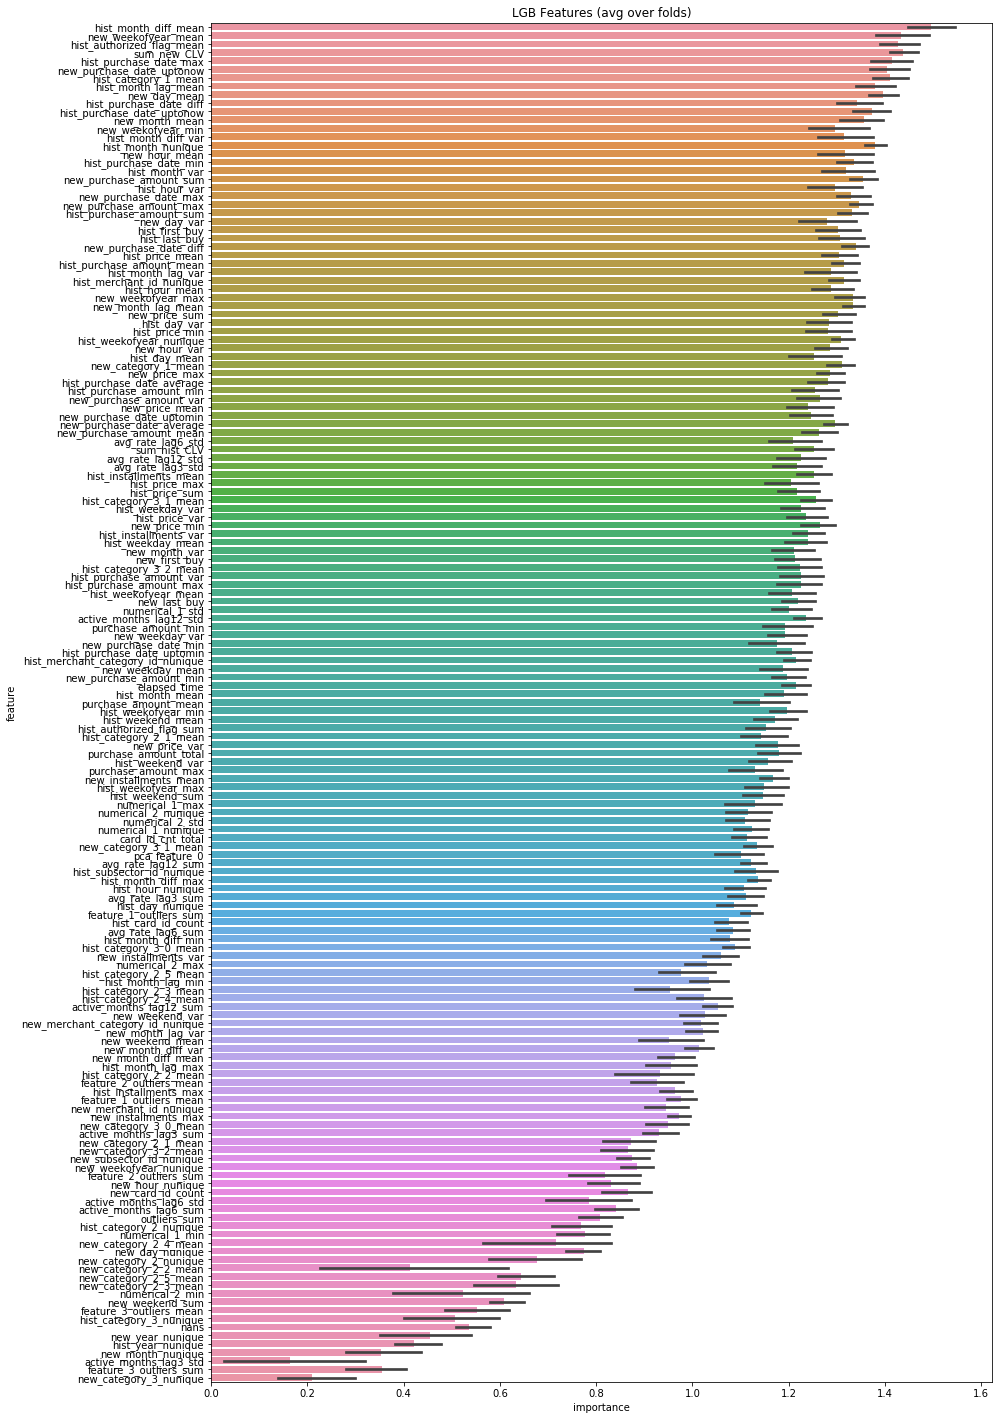

In [443]:
feature_importance['importance'] /= NFOLD
cols = feature_importance[['feature', 'importance']].groupby('feature').mean().sort_values(by='importance', ascending=False)[:200].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
best_features = best_features.sort_values(by='importance', ascending=False)

plt.figure(figsize=(14, 25))
plt.title('LGB Features (avg over folds)')
sns.barplot(x='importance', y='feature', data=best_features)
plt.show()

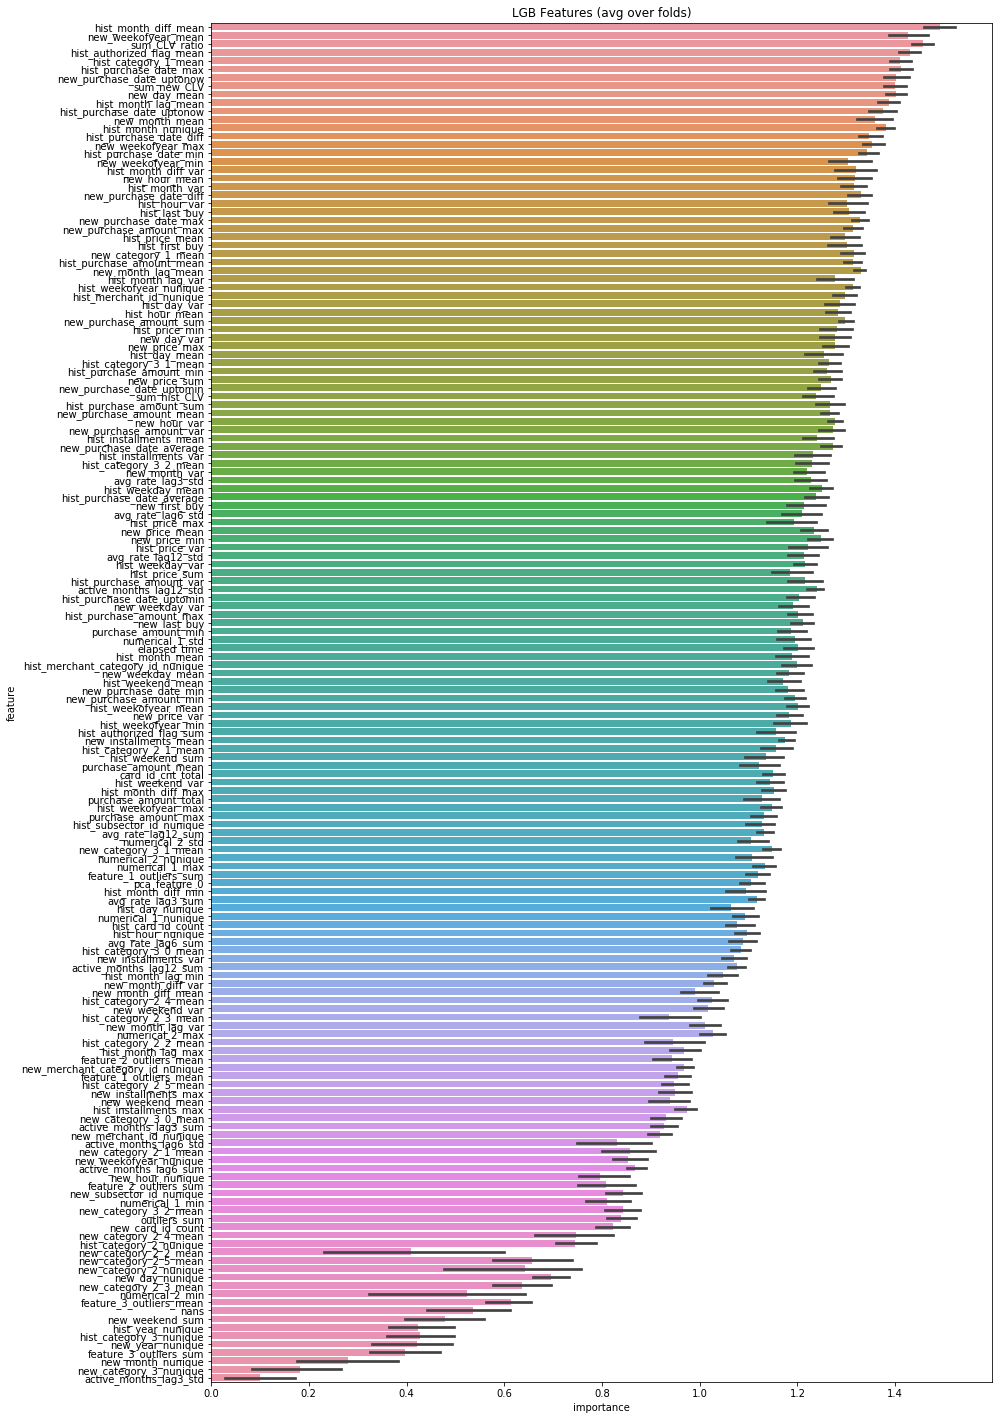

In [422]:
feature_importance['importance'] /= NFOLD
cols = feature_importance[['feature', 'importance']].groupby('feature').mean().sort_values(by='importance', ascending=False)[:200].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
best_features = best_features.sort_values(by='importance', ascending=False)

plt.figure(figsize=(14, 25))
plt.title('LGB Features (avg over folds)')
sns.barplot(x='importance', y='feature', data=best_features)
plt.show()

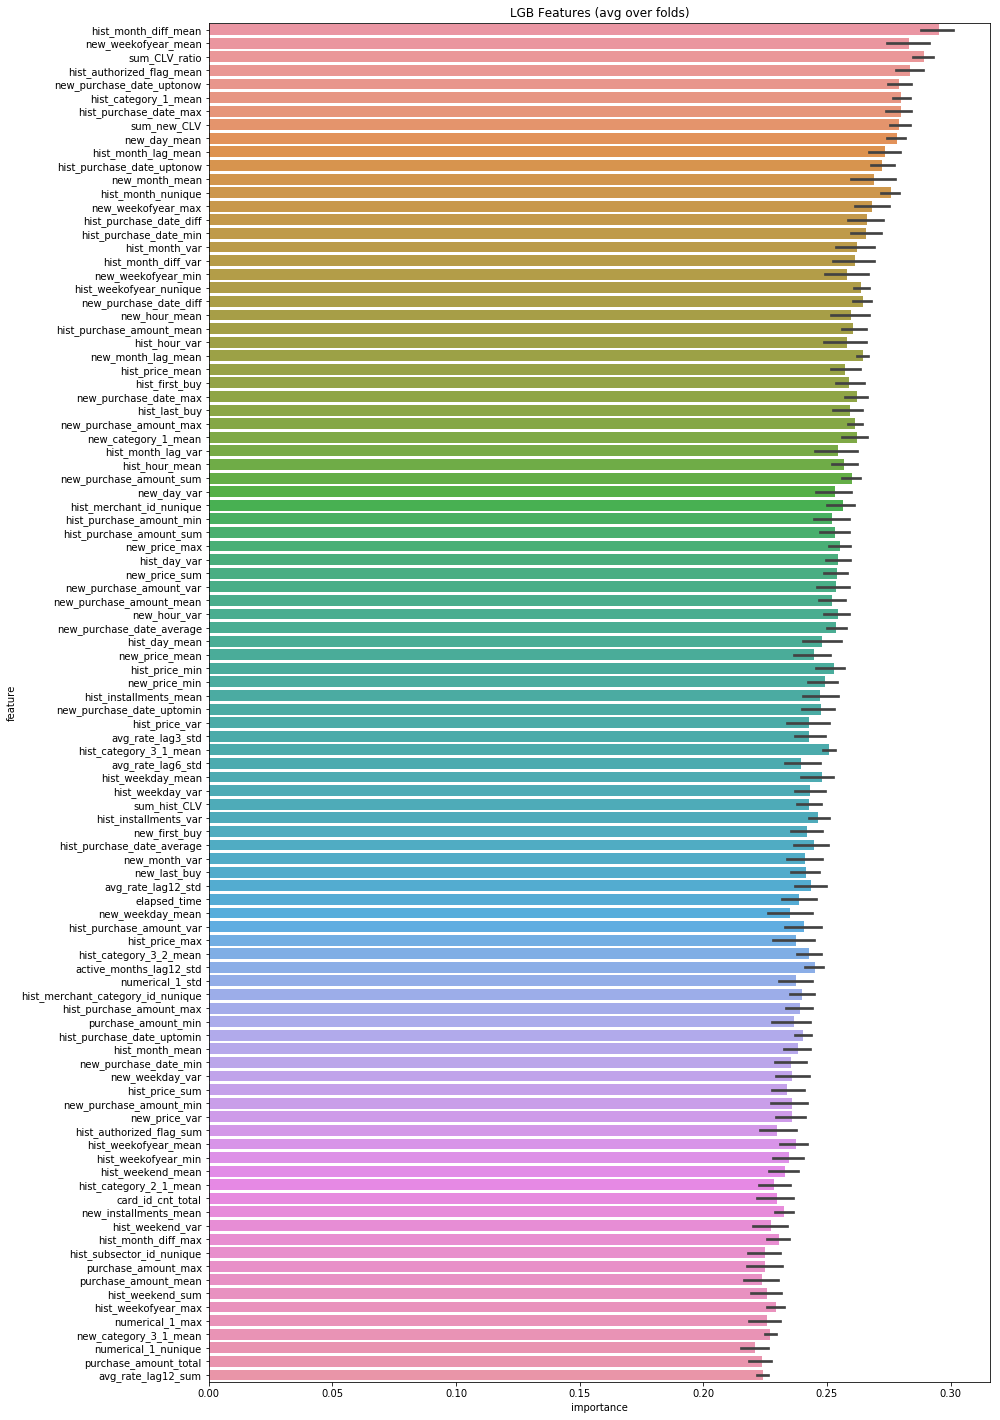

In [329]:
feature_importance['importance'] /= NFOLD
cols = feature_importance[['feature', 'importance']].groupby('feature').mean().sort_values(by='importance', ascending=False)[:100].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
best_features = best_features.sort_values(by='importance', ascending=False)

plt.figure(figsize=(14, 25))
plt.title('LGB Features (avg over folds)')
sns.barplot(x='importance', y='feature', data=best_features)
plt.show()

In [682]:
pd.read_pickle('../remove_outlier_feature/f134.pkl')

,card_id,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag,hist_count_agg_flag
0,C_ID_00007093c1,4.0,1.0,9.0,NaN,NaN,NaN,12.0,NaN,1.0,7.0,4.0,6.0,8.0,6.0,7.0,2.0,5.0,6.0,4.0,5.0,2.0,NaN,4.0,9.0,1.0,6.0,5.0,1.0,NaN,7.0,2.0,3.0,8.0,NaN,NaN,13.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,C_ID_0001238066,2.0,5.0,6.0,7.0,7.0,9.0,4.0,9.0,21.0,8.0,6.0,12.0,9.0,8.0,9.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C_ID_0001506ef0,2.0,NaN,5.0,NaN,1.0,1.0,1.0,5.0,NaN,NaN,NaN,NaN,1.0,NaN,3.0,NaN,NaN,2.0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0,2.0,NaN,2.0,4.0,1.0,10.0,5.0,3.0,5.0,1.0,NaN,2.0,5.0,NaN,NaN,NaN
3,C_ID_0001793786,2.0,6.0,NaN,NaN,7.0,7.0,2.0,6.0,9.0,15.0,NaN,4.0,NaN,7.0,14.0,16.0,3.0,NaN,26.0,8.0,12.0,1.0,22.0,24.0,5.0,NaN,13.0,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C_ID_000183fdda,2.0,1.0,4.0,8.0,8.0,9.0,9.0,8.0,6.0,3.0,3.0,4.0,12.0,2.0,9.0,17.0,7.0,14.0,12.0,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,C_ID_00024e244b,7.0,1.0,NaN,NaN,1.0,2.0,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,9.0,NaN,8.0,7.0,1.0,1.0,3.0,NaN,NaN,1.0,NaN,1.0,NaN,7.0,NaN,NaN,5.0,NaN,NaN,2.0,NaN,NaN
6,C_ID_0002709b5a,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0,NaN,1.0,6.0,NaN,NaN,7.0,NaN,1.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,3.0,NaN,7.0,3.0,2.0,6.0,4.0,NaN,8.0,2.0,NaN,1.0,1.0,NaN,NaN
7,C_ID_00027503e2,1.0,5.0,1.0,NaN,NaN,5.0,5.0,2.0,3.0,NaN,NaN,2.0,2.0,2.0,1.0,NaN,NaN,4.0,1.0,2.0,2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,C_ID_000298032a,1.0,NaN,2.0,1.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,1.0,3.0,NaN,NaN,NaN,4.0,NaN,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,C_ID_0002ba3c2e,4.0,2.0,NaN,NaN,NaN,NaN,NaN,9.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,5.0,9.0,4.0,7.0,14.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# shape

In [ ]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X.iloc[valid_index])
shap.summary_plot(shap_values, X.iloc[valid_index], max_display=200)